#From Stray to Stay:  Leveraging Data to Improve Pet Adoption and Shelter Efficiency

## **Problem Definition:**
This project analyzes Austin Animal Center intake and outcome data, to uncover factors influencing adoption rates and shelter stay duration. By examining breed, age, intake reasons, and demographic patterns, we aim to identify trends, potential biases, and actionable insights. The goal is to support data-driven strategies that improve shelter efficiency, enhance adoption campaigns, and inform equitable, evidence-based animal welfare policies.

## **Motivation**


As pet companionship becomes increasingly important in modern life, the number of animals entering shelters continues to rise. This project aims to better understand adoption dynamics not only to support animal welfare, but also to uncover actionable insights that can guide resource planning, outreach strategy, and sustainable adoption programs.

## **Data Source**

Austin Animal Center Outcomes (10/01/2013 to 05/05/2025)

https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes-10-01-2013-to-05-05-/9t4d-g238/about_data

Austin Animal Center Intakes (10/01/2013 to 05/05/2025)


https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes-10-01-2013-to-05-05-2/wter-evkm/about_data

Our datasets comes from the Austin Animal Center, part of the Government / Health and Community Services sector. Each dataset contains approximately 174,000 rows and 12 columns, with a total size of about 30 MB.

License:	Public Domain

Source Link	http://www.austintexas.gov/department/animal-services


## **Executive Summary**

This study analyzes Austin Animal Center intake and outcome data (2020–2025) to characterize shelter demand, animal populations, and outcome patterns using a cleaned, high-integrity dataset with a 98.4% intake–outcome match rate. Seasonal peaks in spring and summer indicate the need for adaptive staffing and medical capacity. Dogs and cats dominate the intake population, and dogs show a notably higher repeat-intake rate—more than three times that of cats—highlighting the importance of targeted behavioral or owner-support interventions to reduce repeated shelter cycling. Coat color significantly predicts adoption likelihood, with lighter or patterned animals exhibiting higher adoption rates. Outcome distributions confirm Austin’s strong no-kill performance, while length-of-stay varies widely by outcome type. Spatial analysis highlights concentrated stray hotspots along major roads in Austin and Travis County. These findings support data-driven improvements in resource allocation, adoption strategy, and future predictive modeling.



# **Tableau**

### **Tableau Link 1:**


https://public.tableau.com/views/TeamA02/dataoverview?:language=en-US&publish=yesn&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

### **Tableau Link 2**:

https://public.tableau.com/views/TeamA02-dashboard2/IntakeOutcomeBehaviorAnalytics?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

## **Tableau Dashboard**
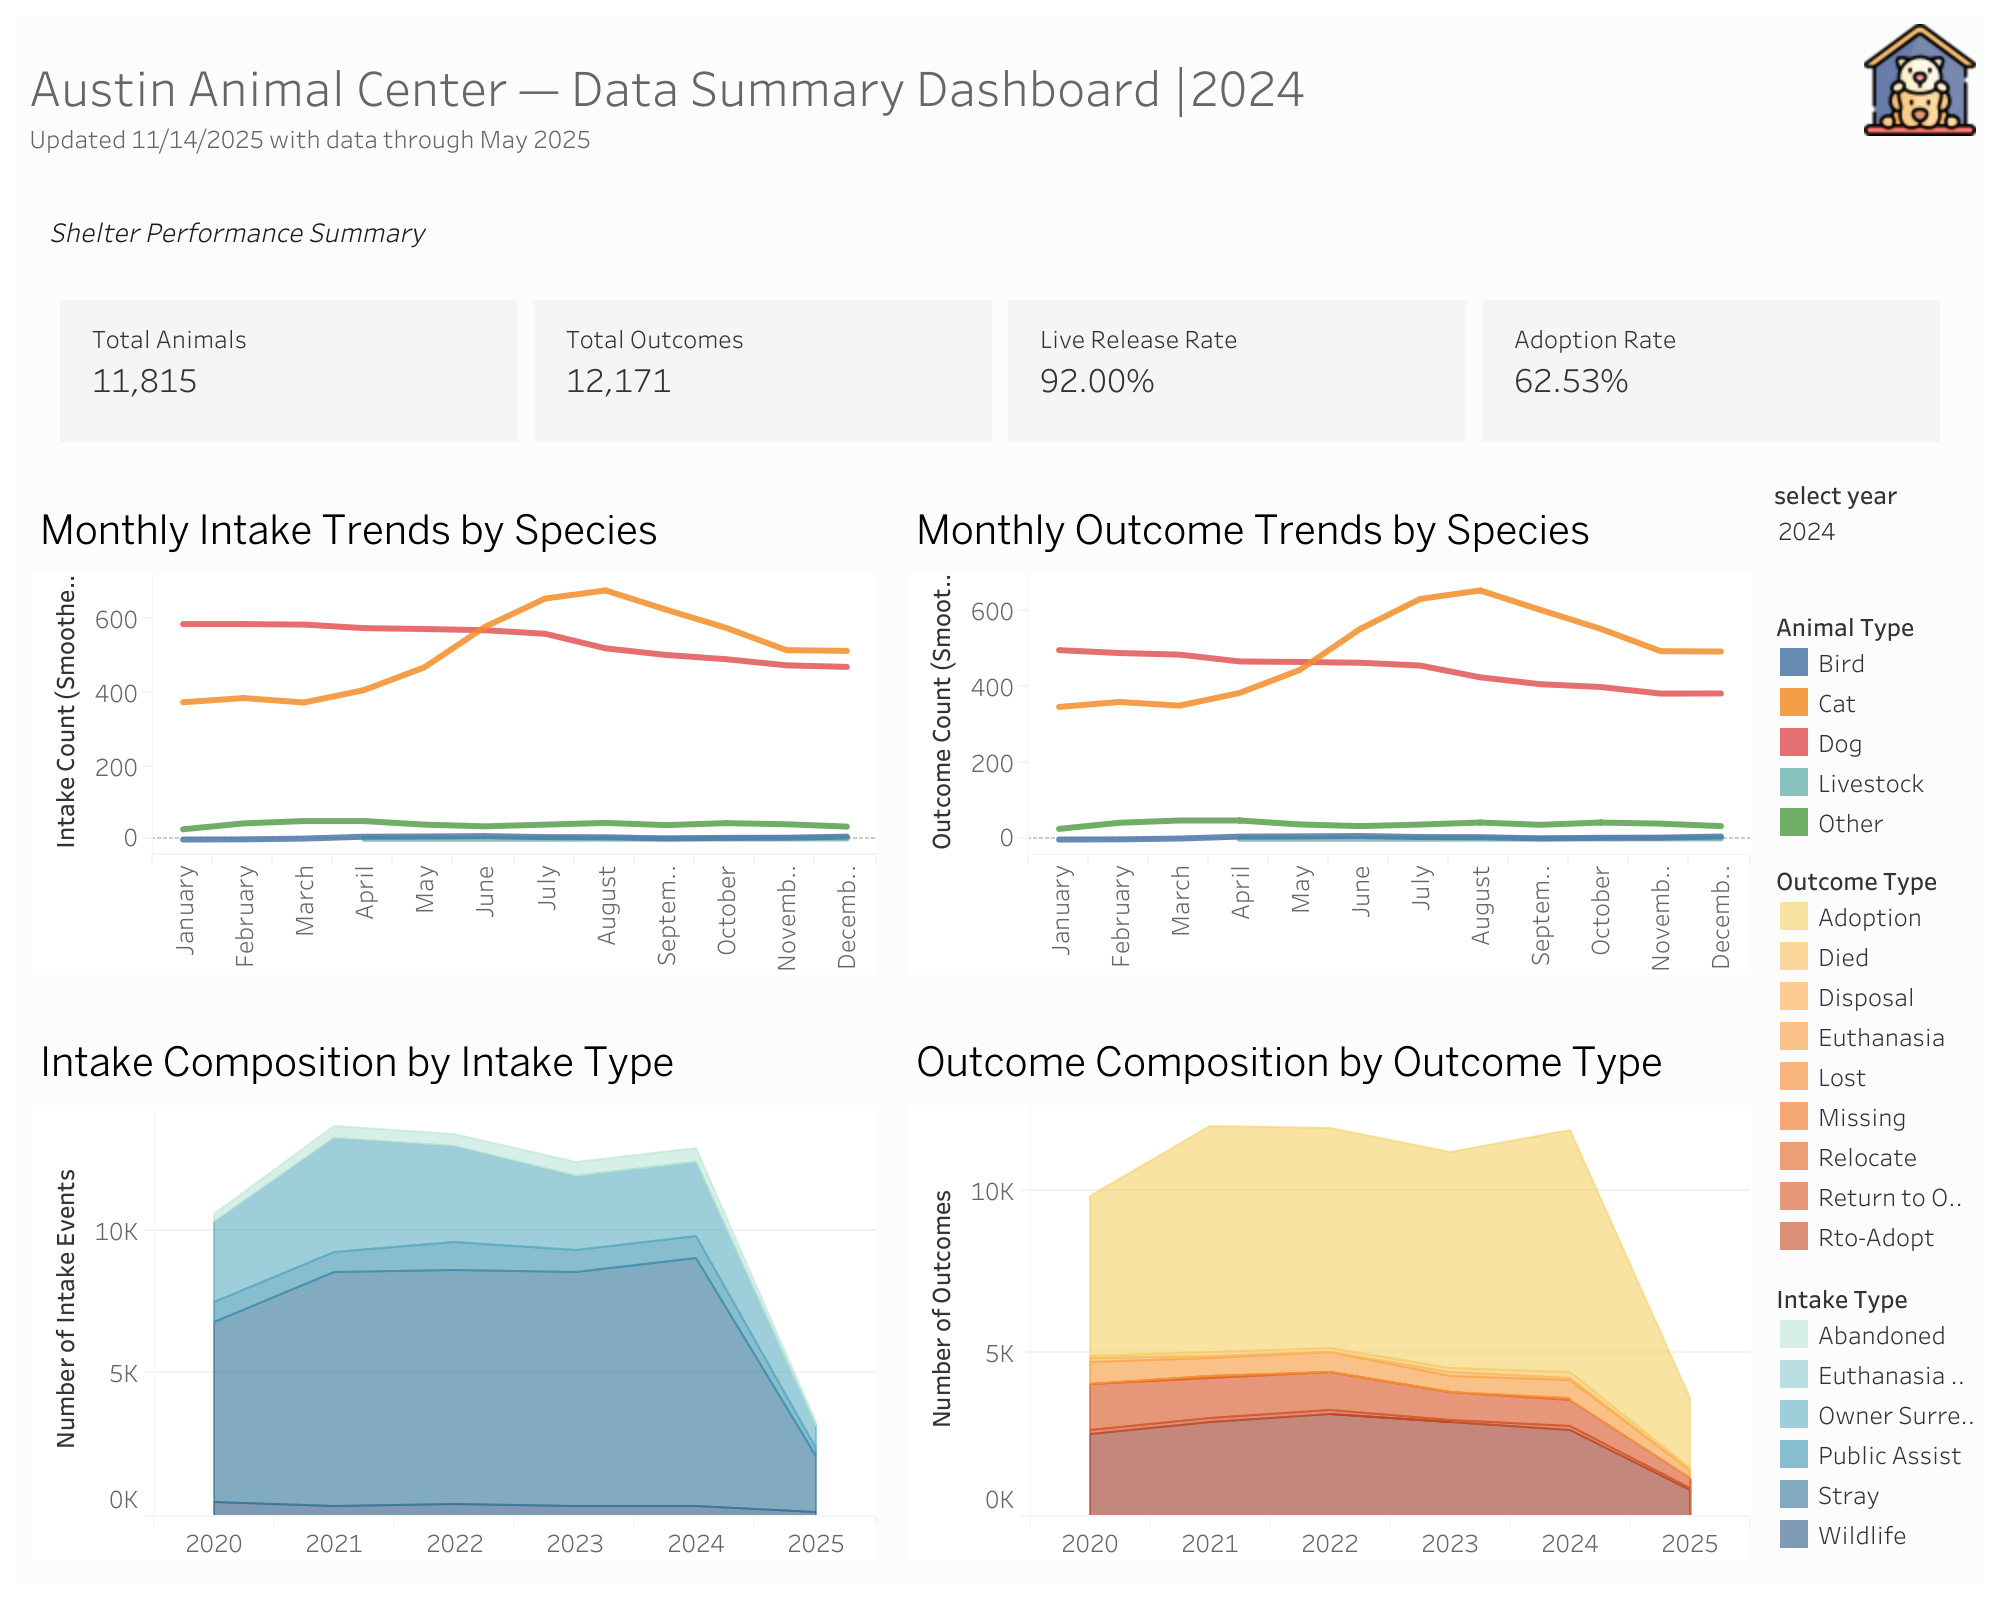

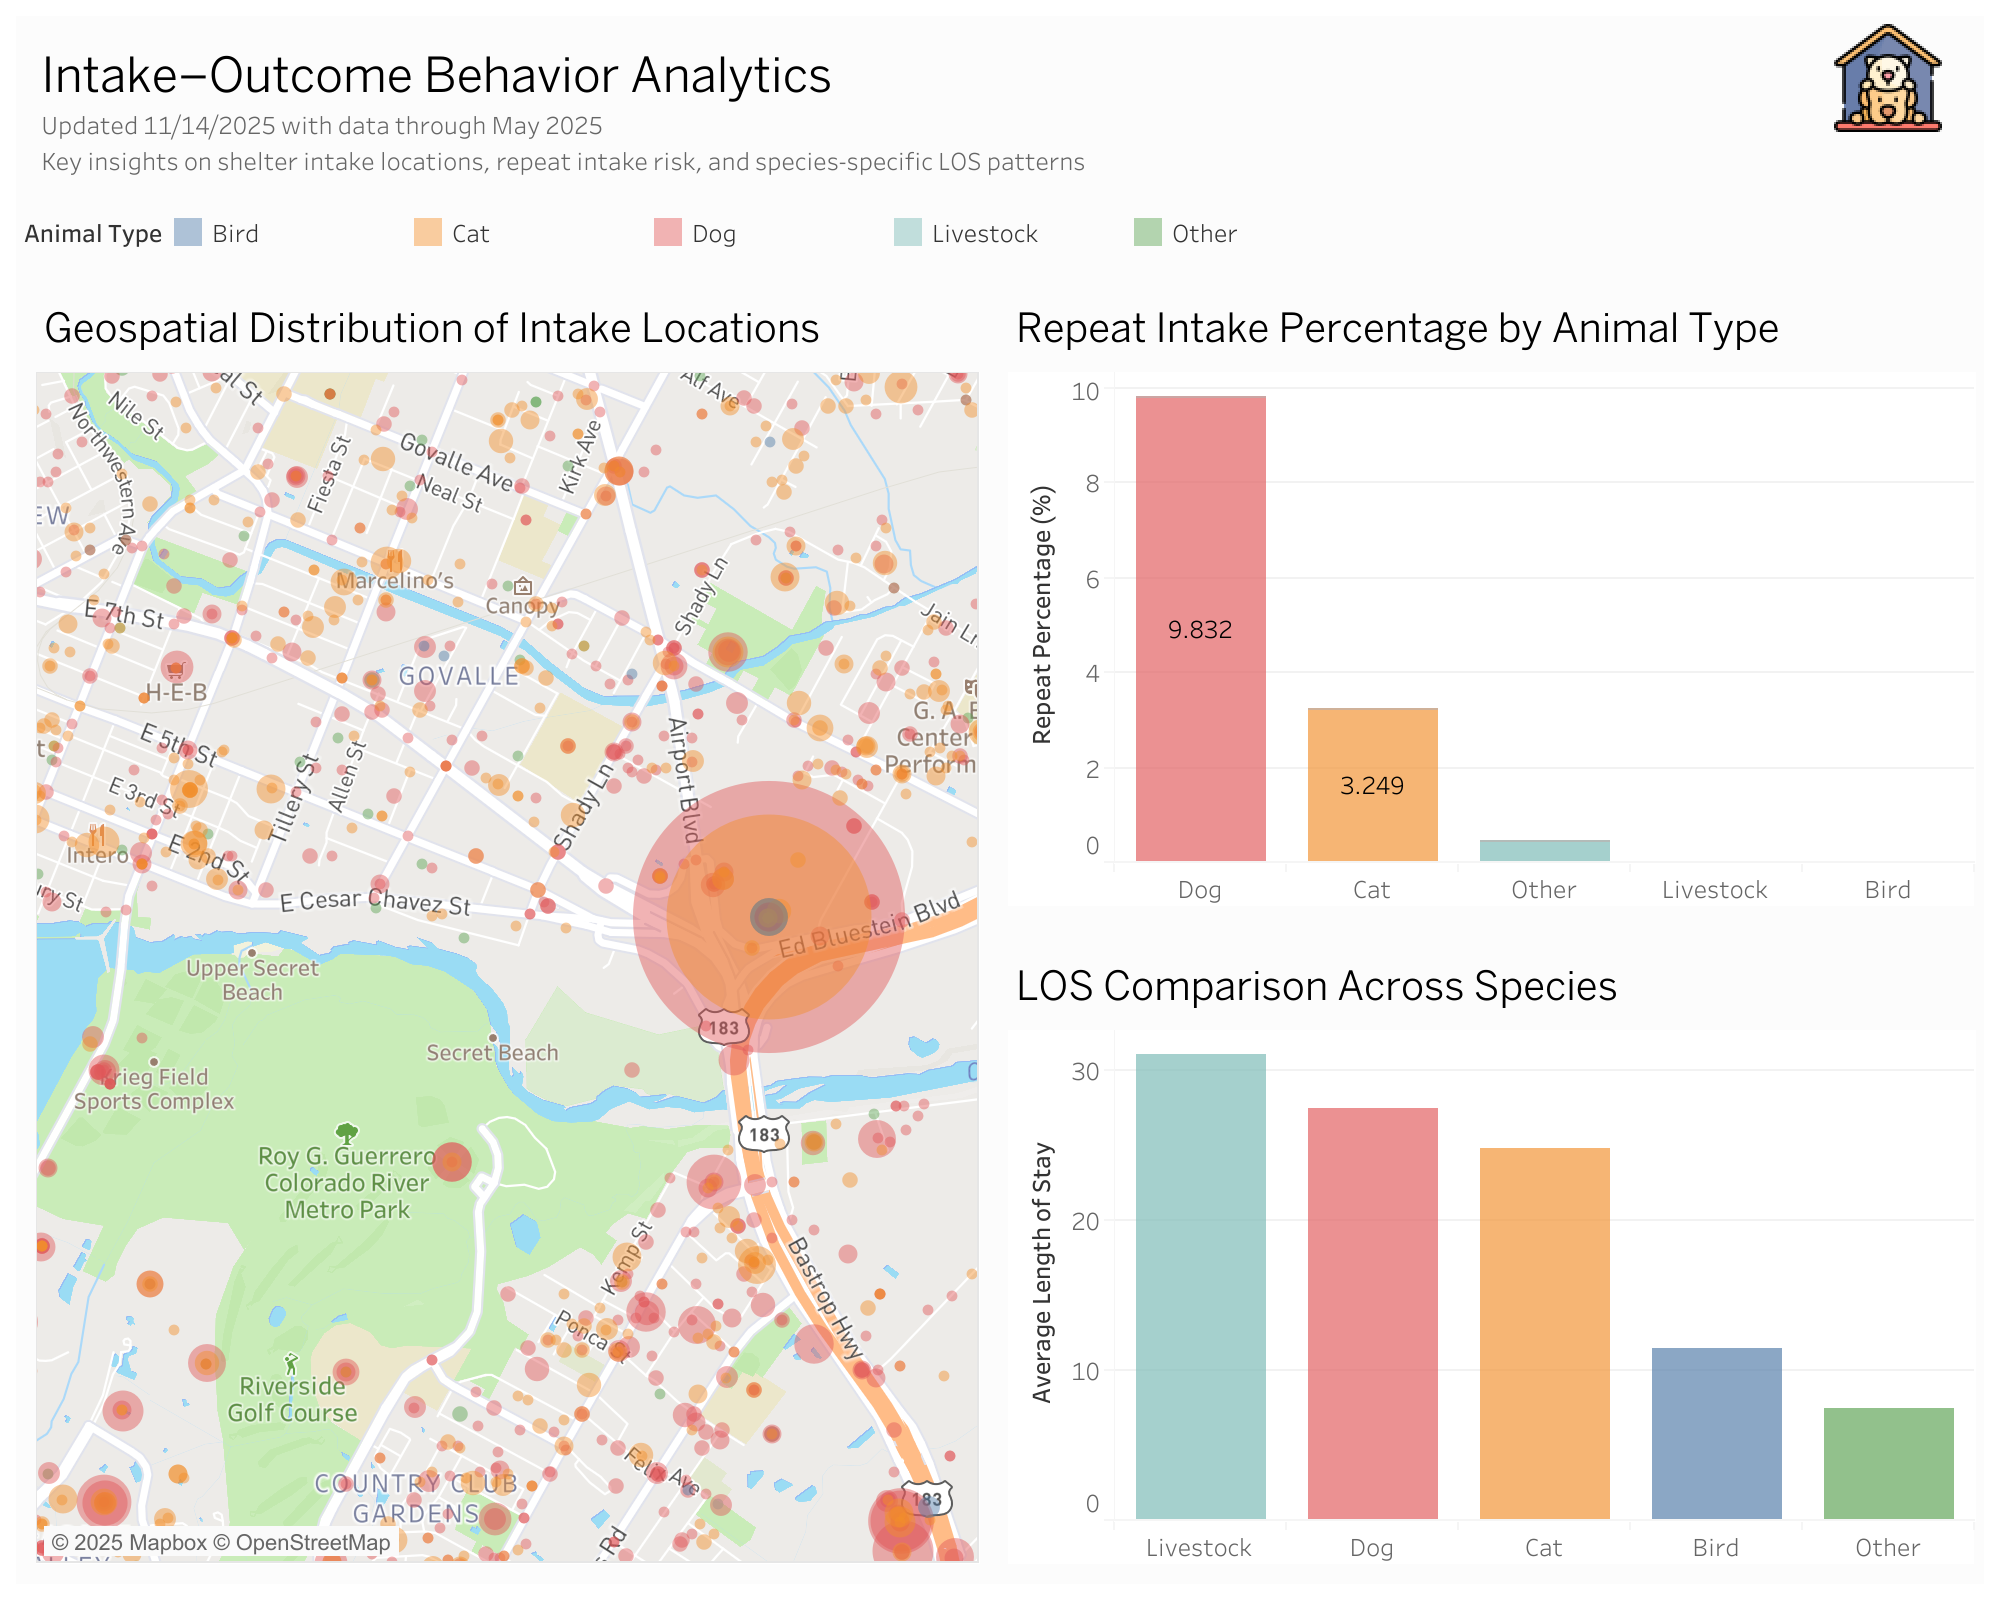

#**Entity Relationship Diagram**

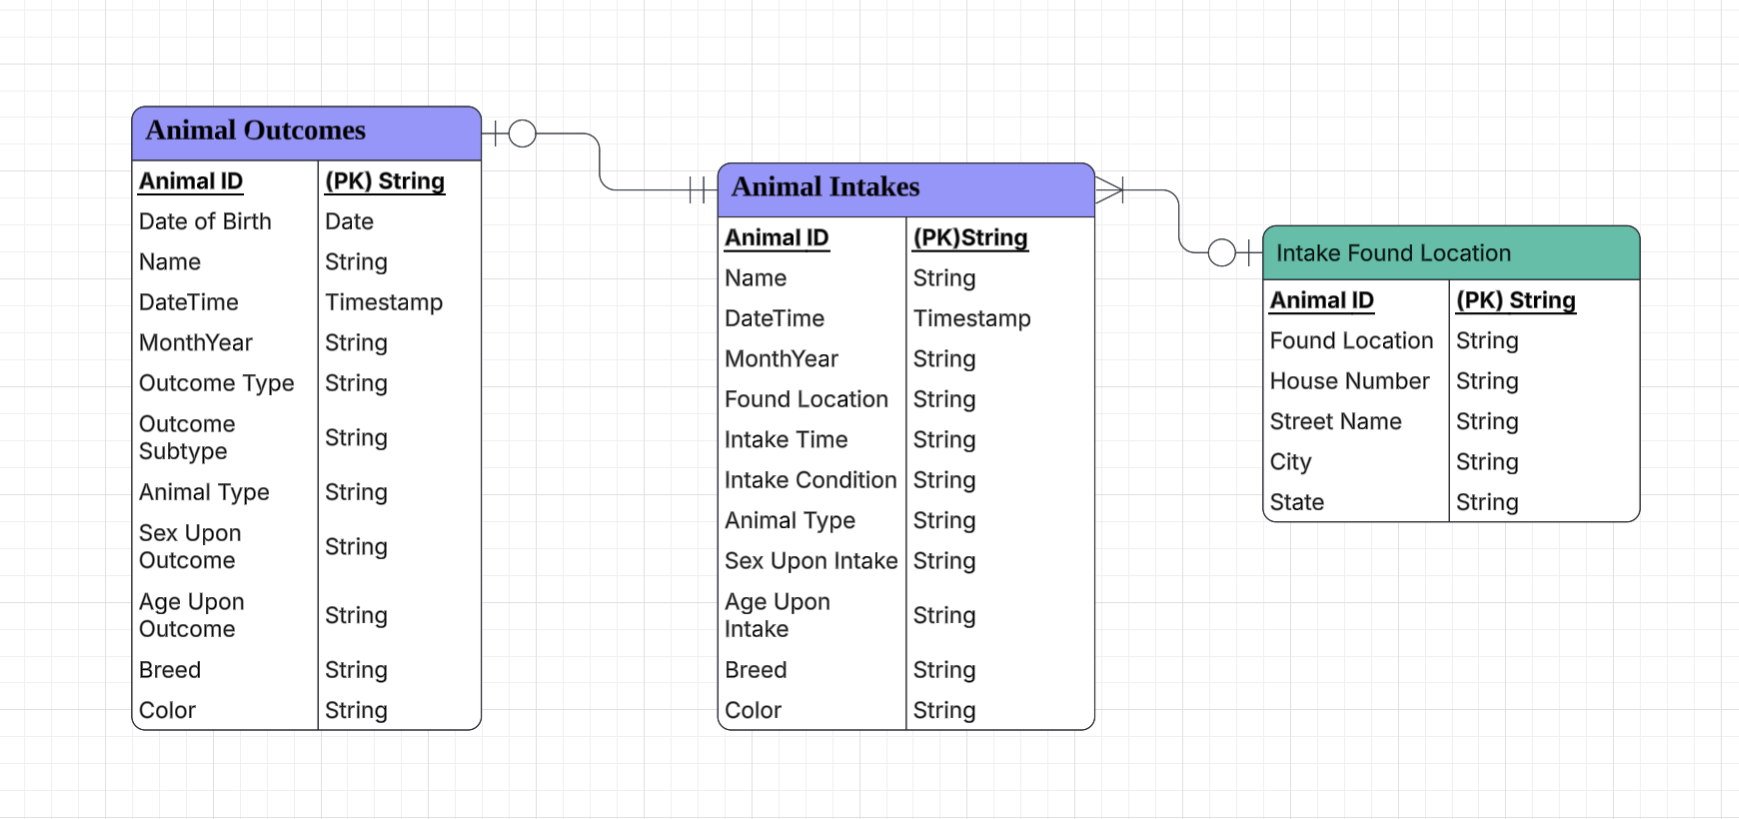

**🦜 Animal Intake Data Dictionary**
| **Column Name**      | **Description**                                                 | **Data Type** |
| -------------------- | --------------------------------------------------------------- | ------------- |
| **Animal ID**        | Unique identifier assigned to each animal                       | String        |
| **Name**             | Name of the animal, if known                                    | String        |
| **DateTime**         | Exact date and time the animal entered the shelter              | Timestamp     |
| **MonthYear**        | Month-year value derived from DateTime                          | String        |
| **Found Location**   | Location where the animal was found                             | String        |
| **Intake Type**      | Reason or category of intake (e.g., Stray, Owner Surrender)     | String        |
| **Intake Condition** | Condition of the animal at intake (e.g., Normal, Sick, Injured) | String        |
| **Animal Type**      | Species classification (Dog, Cat, etc.)                         | String        |
| **Sex upon Intake**  | Sex and reproductive status at intake                           | String        |
| **Age upon Intake**  | Estimated age at intake                                         | String        |
| **Breed**            | Recorded breed(s) of the animal                                 | String        |
| **Color**            | Color description of the animal                                 | String        |
| **Intake Time**            | Exact date and time the animal entered the shelter(Cleaned)                                 | Timestamp        |


**🐕 Animal Outcome Data Dictionary**
| **Column Name**      | **Description**                                                 | **Data Type** |
| -------------------- | --------------------------------------------------------------- | ------------- |
| **Animal ID**        | Unique identifier matching intake records                       | String        |
| **Date of Birth**    | Birth date of the animal, if known                              | Date          |
| **Name**             | Name of the animal                                              | String        |
| **DateTime**         | Exact date and time the animal left the shelter                 | Timestamp     |
| **MonthYear**        | Month-year value derived from DateTime                          | String        |
| **Outcome Type**     | Category of outcome (Adoption, Transfer, Return to Owner, etc.) | String        |
| **Outcome Subtype**  | Additional detail about outcome                                 | String        |
| **Animal Type**      | Species classification                                          | String        |
| **Sex upon Outcome** | Sex and reproductive status at outcome                          | String        |
| **Age upon Outcome** | Estimated age at outcome                                        | String        |
| **Breed**            | Recorded breed(s)                                               | String        |
| **Color**            | Color description                                               | String        |
| **Outcome Time**            | Exact date and time the animal left the shelter(Cleaned)                                 | Timestamp        |


**🐈Intake Found Location Data Dictionary**
<div style="font-size: 14px;">

| **Column Name**      | **Description**                                         | **Data Type**  |
|----------------------|---------------------------------------------------------|----------------|
| **Animal ID**         | Unique identifier assigned to each animal               | STRING         |
| **house_number**      | House number of the animal's found location             | STRING         |
| **street_name**       | Street name where the animal was found                  | STRING         |
| **city**              | City where the animal was found                         | STRING         |
| **state**             | State where the animal was found                        | STRING         |
</div>


In [1]:
from google.cloud import bigquery
client = bigquery.Client()

from google.colab import auth
auth.authenticate_user()

##1. Data Cleaning

Before / After Cleaning Summary：



| **Column**                             | **Issue Identified**                                           | **Action (SQL Transformation)**                                                               | **Justification**                                                                                  |
| -------------------------------------- | -------------------------------------------------------------- | --------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------- |
| **DateTime (Intake & Outcome)**        | Some timestamps had invalid years recorded as `00xx`           | `REGEXP_REPLACE(CAST(DateTime AS STRING), r'^00(\d{2})', r'20\1')` + `SAFE.PARSE_TIMESTAMP()` | Ensures timestamps are valid and allows accurate temporal analysis for trends and LOS.             |
| **Full Record (All Columns)**          | Presence of exact duplicate rows                               | `SELECT DISTINCT *` when creating `*_2020_2025_clean` tables                                  | Removes erroneous duplication while preserving correct multiple-intake events for the same animal. |
| **Age upon Intake / Age upon Outcome** | Negative ages and potential invalid formats                    | `WHERE NOT (Age LIKE '-%')` and regex validation checks                                       | Eliminates biologically impossible values and ensures age-related modeling is credible.            |
| **Found Location**                     | Unstructured, inconsistent address strings                     | `REGEXP_EXTRACT()` to derive `house_number`, `street_name`, `city`, `state`                   | Converts messy text into structured geographic features, enabling mapping and hotspot analysis.    |
| **Analysis Window (All Columns)**      | Dataset spans 2013–2025; analysis needs a consistent timeframe | `EXTRACT(YEAR FROM Intake_Time) BETWEEN 2020 AND 2025`                                        | Focuses on recent, more relevant data and avoids noise from legacy records.                        |
| **Outcome Matching (Animal ID)**       | Some intake records not matched to outcomes                    | `LEFT JOIN` + count comparison                                                                | Verifies data completeness and confirms dataset integrity (98.4% match rate).                      |
| **Animal Name**                        | Missing values                                                 | Accepted as-is (no SQL operation)                                                             | Name does not impact modeling or analysis, so no imputation needed.                                |



Before cleaning, the dataset contained inconsistent timestamps (including *00xx* years), unstructured address formats, exact duplicate rows mixed with valid repeat-intake events, and a small number of invalid age values. After applying regex-based timestamp repair, structured address extraction, duplicate removal, and age validation, the data is now standardized, accurate, and analysis-ready. These improvements enable reliable temporal trends, geographic insights, and outcome modeling across the 2020–2025 period.

1.1 Overview of intake the data

In [2]:
%%bigquery --project ba775-team2-project
SELECT *
FROM `ba775-team2-project.Austin_Animal_Center_Data.Intake_2013_2025_Period`
LIMIT 5


Query is running:   0%|          |

Downloading:   0%|          |

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A795857,None,2019-05-25 13:43:00+00:00,May-19,202 North Lake Hills Drive in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Abyssinian,Torbie/White
1,A795859,None,2019-05-25 13:43:00+00:00,May-19,202 North Lake Hills Drive in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Abyssinian,Torbie
2,A798848,None,2019-07-01 13:05:00+00:00,Jul-19,13301 Dearbonne Drive in Travis (TX),Stray,Normal,Cat,Intact Female,1 year,Abyssinian,Torbie
3,A800187,None,2019-07-17 13:47:00+00:00,Jul-19,1101 Brodie Street in Austin (TX),Stray,Normal,Cat,Unknown,1 year,Abyssinian,Brown
4,A800331,None,2019-07-19 13:26:00+00:00,Jul-19,8505 Mayview Drive in Austin (TX),Stray,Normal,Cat,Intact Female,1 year,Abyssinian,Brown Tabby


1.2 Select the time scope of analysis

We choose to conduct analysis on the most recent 5 years of data.
We also observed that some legacy timestamps were recorded as `00xx` (e.g., `0019-05-03`). To fix this, we used a regular expression to automatically replace `00xx` → `20xx`.


In [3]:
%%bigquery --project ba775-team2-project

CREATE OR REPLACE TABLE
 `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025` AS


SELECT
 *
FROM (
 SELECT
   *,
   COALESCE(
     SAFE.PARSE_TIMESTAMP(
       '%Y-%m-%d %H:%M:%S%Ez',
       REGEXP_REPLACE(CAST(DateTime AS STRING), r'^00(\d{2})', r'20\1')
     ),
     SAFE.PARSE_TIMESTAMP(
       '%Y-%m-%d %H:%M:%S',
       REGEXP_REPLACE(CAST(DateTime AS STRING), r'^00(\d{2})', r'20\1')
     )
   ) AS Intake_Time
 FROM
   `ba775-team2-project.Austin_Animal_Center_Data.Intake_2013_2025_Period`
)
WHERE
 EXTRACT(YEAR FROM Intake_Time) BETWEEN 2020 AND 2025;

Query is running:   0%|          |

""


1.3 Indentify missing value

 The dataset is largely complete, no need for futher imputation; the only missing attribute is the animal name, which does not affect our analysis.

In [4]:
%%bigquery --project ba775-team2-project
SELECT
  SUM(CASE WHEN `Animal ID` IS NULL THEN 1 ELSE 0 END) AS missing_animal_id,
  SUM(CASE WHEN Name IS NULL THEN 1 ELSE 0 END) AS missing_name,
  SUM(CASE WHEN DateTime IS NULL THEN 1 ELSE 0 END) AS missing_datetime,
  SUM(CASE WHEN `Found Location` IS NULL THEN 1 ELSE 0 END) AS missing_location,
  SUM(CASE WHEN `Intake Type` IS NULL THEN 1 ELSE 0 END) AS missing_intake_type,
  SUM(CASE WHEN `Intake Condition` IS NULL THEN 1 ELSE 0 END) AS missing_condition,
  SUM(CASE WHEN `Animal Type` IS NULL THEN 1 ELSE 0 END) AS missing_animal_type,
  SUM(CASE WHEN `Sex upon Intake` IS NULL THEN 1 ELSE 0 END) AS missing_sex,
  SUM(CASE WHEN `Age upon Intake` IS NULL THEN 1 ELSE 0 END) AS missing_age,
  SUM(CASE WHEN Breed IS NULL THEN 1 ELSE 0 END) AS missing_breed,
  SUM(CASE WHEN Color IS NULL THEN 1 ELSE 0 END) AS missing_color
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025`;


Query is running:   0%|          |

Downloading:   0%|          |

,missing_animal_id,missing_name,missing_datetime,missing_location,missing_intake_type,missing_condition,missing_animal_type,missing_sex,missing_age,missing_breed,missing_color
0,0,14665,0,0,0,0,0,0,0,0,0


1.4 Find and investigate duplicate cases

The query results turn out as not exact duplicates, but partial duplicates.
Based on further understanding of the organization data, we found that the shelter data is event-based rather than an animal-level record. Each intake represents a new event, even if it involves the same animal.
The Animal ID is used to track the same animal across events, while DateTime + Intake Type together identify each unique intake.

In [5]:
%%bigquery --project ba775-team2-project
with duplicate_case as (SELECT
 `Animal ID`,
 COUNT(*) AS occurrences
FROM
 `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025`
GROUP BY
 `Animal ID`
HAVING
 COUNT(*) > 1
ORDER BY
 occurrences DESC)


select *
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025`
INNER JOIN duplicate_case using (`Animal ID`)
limit 10

Query is running:   0%|          |

Downloading:   0%|          |

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Intake_Time,occurrences
0,A889917,Chip,2023-09-29 13:31:00+00:00,Sep-23,805 El Viejo Camino in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Abyssinian,Agouti,2023-09-29 13:31:00+00:00,2
1,A889917,Chip,2024-11-04 14:04:00+00:00,Nov-24,1714 E Parmer Lane in Austin (TX),Stray,Normal,Cat,Spayed Female,1 year,Abyssinian,Agouti,2024-11-04 14:04:00+00:00,2
2,A860247,Lincoln Aka Luke,2022-10-28 12:58:00+00:00,Oct-22,Outside Jurisdiction,Owner Surrender,Normal,Dog,Neutered Male,1 year,Affenpinscher Mix,Brown,2022-10-28 12:58:00+00:00,2
3,A860247,Lincoln Aka Luke,2022-06-24 18:24:00+00:00,Jun-22,7101 North Ih 35 in Austin (TX),Public Assist,Normal,Dog,Intact Male,8 months,Affenpinscher Mix,Brown,2022-06-24 18:24:00+00:00,2
4,A872036,Buddy,2023-04-28 16:54:00+00:00,Apr-23,Grayledge Drive And Valley Forge Drive in Aust...,Stray,Normal,Dog,Neutered Male,2 years,Akbash Mix,White,2023-04-28 16:54:00+00:00,2
5,A872036,Buddy,2023-08-09 15:33:00+00:00,Aug-23,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,2 years,Akbash Mix,White,2023-08-09 15:33:00+00:00,2
6,A821472,Sgt Amor Aka Sarge,2022-04-21 16:27:00+00:00,Apr-22,Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Akita,White,2022-04-21 16:27:00+00:00,2
7,A821472,Sgt Amor Aka Sarge,2022-05-05 15:08:00+00:00,May-22,Austin (TX),Public Assist,Normal,Dog,Neutered Male,4 years,Akita,White,2022-05-05 15:08:00+00:00,2
8,A823791,Luca,2020-10-06 17:02:00+00:00,Oct-20,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,1 year,Akita,Black/White,2020-10-06 17:02:00+00:00,3
9,A823791,Luca,2020-09-30 11:54:00+00:00,Sep-20,Mckinney Falls Parkway And East William Cannon...,Stray,Normal,Dog,Intact Male,1 year,Akita,Black/White,2020-09-30 11:54:00+00:00,3


1.5 Remove exact dupilicates

In [6]:
%%bigquery --project ba775-team2-project

-- Identify duplicates and create a cleaned version in one query
CREATE OR REPLACE TABLE `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean` AS
WITH duplicates AS (
  SELECT
    `Animal ID`,
    COUNT(*) AS duplicate_count
  FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025`
  GROUP BY
    `Animal ID`,
    `Name`,
    `DateTime`,
    `MonthYear`,
    `Found Location`,
    `Intake Type`,
    `Intake Condition`,
    `Animal Type`,
    `Sex upon Intake`,
    `Age upon Intake`,
    `Breed`,
    `Color`
  HAVING COUNT(*) > 1
)
SELECT DISTINCT *
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025`;


Query is running:   0%|          |

""


In [7]:
%%bigquery --project ba775-team2-project
SELECT *
from `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`
limit 5

Query is running:   0%|          |

Downloading:   0%|          |

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color,Intake_Time
0,A814353,Tot,2020-02-28 13:04:00+00:00,Feb-20,12670 Lime Creek Rd in Leander (TX),Stray,Normal,Cat,Neutered Male,4 months,Abyssinian,Brown Tabby/White,2020-02-28 13:04:00+00:00
1,A828129,None,2021-01-08 13:11:00+00:00,Jan-21,11214 Amethyst in Austin (TX),Stray,Normal,Cat,Intact Male,2 years,Abyssinian,Brown/Black,2021-01-08 13:11:00+00:00
2,A857039,Kumi,2022-05-11 12:47:00+00:00,May-22,Austin (TX),Abandoned,Normal,Cat,Intact Female,2 years,Abyssinian,Silver,2022-05-11 12:47:00+00:00
3,A885067,*Amira,2023-07-12 14:51:00+00:00,Jul-23,6704 Panda Royal in Austin (TX),Stray,Normal,Cat,Intact Female,3 weeks,Abyssinian,Brown Tabby,2023-07-12 14:51:00+00:00
4,A887798,None,2023-08-26 15:39:00+00:00,Aug-23,Anderson Mill Rd And Pond Springs Rd in Austin...,Stray,Normal,Cat,Intact Male,3 weeks,Abyssinian,Brown Tabby,2023-08-26 15:39:00+00:00


1.6 Conduct data quality check on the Age

Only two records have negative ages, and no other quality issues (missing, invalid format, or extreme ages) were detected.
Since the number of negative-age records is very small, we will remove them directly to ensure data consistency before standardizing the age column.

In [8]:
%%bigquery --project ba775-team2-project
SELECT
  COUNT(*) AS total_rows,
  COUNTIF(`Age upon Intake` IS NULL OR `Age upon Intake` = '') AS missing_age,
  COUNTIF(`Age upon Intake` LIKE '-%') AS negative_age,
  COUNTIF(
    NOT REGEXP_CONTAINS(LOWER(`Age upon Intake`), r'(day|week|month|year)')
  ) AS invalid_age_format,
  COUNTIF(
    SAFE_CAST(REGEXP_EXTRACT(`Age upon Intake`, r'([0-9]+)') AS INT64) > 30
    AND LOWER(`Age upon Intake`) LIKE '%year%'
  ) AS extreme_age_over_30


FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025`;






Query is running:   0%|          |

Downloading:   0%|          |

,total_rows,missing_age,negative_age,invalid_age_format,extreme_age_over_30
0,60318,0,2,0,0


In [9]:
%%bigquery --project ba775-team2-project

CREATE OR REPLACE TABLE `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean` AS
SELECT DISTINCT *
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025`
WHERE NOT (`Age upon Intake` LIKE '-%');


Query is running:   0%|          |

""


1.7 Extract found location table
This Found Location field contains address information recorded at varying levels of detail, e.g.：
1. Complete addresses, including full house number, street, city, and state
Example: 7405 Springtime in Austin (TX)
2. Approximate locations, include only city or county names
Example: Austin (TX) or Burleson in Travis (TX)
3. Other entries, like Outside Jurisdiction

In order to query in different level, we extract and standardize relevant components (e.g., house_number, street_name, city, state).

In [10]:
%%bigquery --project ba775-team2-project
CREATE OR REPLACE TABLE `ba775-team2-project.Austin_Animal_Center_Data.intake_found_location_table` AS
SELECT
 `Animal ID`,
 `Found Location`,


 REGEXP_EXTRACT(TRIM(REGEXP_EXTRACT(`Found Location`, r'^(.*) in')), r'^(\d+)') AS house_number,
 REGEXP_EXTRACT(TRIM(REGEXP_EXTRACT(`Found Location`, r'^(.*) in')), r'^\d+\s+(.*)') AS street_name,
 COALESCE(
   TRIM(REGEXP_EXTRACT(`Found Location`, r'in ([A-Za-z\s]+)\s*\([A-Z]{2}\)')),
   TRIM(REGEXP_EXTRACT(`Found Location`, r'^([A-Za-z\s]+)\s*\([A-Z]{2}\)'))
 ) AS city,

 TRIM(REGEXP_EXTRACT(`Found Location`, r'\(([A-Z]{2})\)')) AS state


FROM
 `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`;


Query is running:   0%|          |

""


1.8 Apply the same quality check logic on the outcomes data

In [11]:
%%bigquery --project ba775-team2-project

CREATE OR REPLACE TABLE `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean` AS
WITH cleaned AS (
  -- 2020–2025
  SELECT
    *,
    COALESCE(
      SAFE.PARSE_TIMESTAMP(
        '%Y-%m-%d %H:%M:%S%Ez',
        REGEXP_REPLACE(CAST(DateTime AS STRING), r'^00(\d{2})', r'20\1')
      ),
      SAFE.PARSE_TIMESTAMP(
        '%Y-%m-%d %H:%M:%S',
        REGEXP_REPLACE(CAST(DateTime AS STRING), r'^00(\d{2})', r'20\1')
      )
    ) AS Outcome_Time
  FROM `ba775-team2-project.Austin_Animal_Center_Data.Outcomes_2013_2025_Period`
  WHERE DateTime IS NOT NULL
),
deduped AS (
  SELECT DISTINCT *
  FROM cleaned
  WHERE EXTRACT(YEAR FROM Outcome_Time) BETWEEN 2020 AND 2025
),
validated AS (

  SELECT *
  FROM deduped
  WHERE NOT (`Age upon Outcome` LIKE '-%')
)

SELECT *
FROM validated;


Query is running:   0%|          |

""


## 2. Data Integrity & Temporal Trends

### 2.1 Do monthly intake/outcome counts show clear seasonal peaks (e.g., more stray animals in summer)?


In [12]:
%%bigquery --project ba775-team2-project
--Intake
SELECT
  CASE
    WHEN EXTRACT(MONTH FROM DateTime) IN (12, 1, 2) THEN 'Winter'
    WHEN EXTRACT(MONTH FROM DateTime) IN (3, 4, 5) THEN 'Spring'
    WHEN EXTRACT(MONTH FROM DateTime) IN (6, 7, 8) THEN 'Summer'
    WHEN EXTRACT(MONTH FROM DateTime) IN (9, 10, 11) THEN 'Autumn'
  END AS season,
  COUNT(*) AS total_rows
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`
WHERE EXTRACT(YEAR FROM DateTime) BETWEEN 2020 AND 2025
GROUP BY
  CASE
    WHEN EXTRACT(MONTH FROM DateTime) IN (12, 1, 2) THEN 'Winter'
    WHEN EXTRACT(MONTH FROM DateTime) IN (3, 4, 5) THEN 'Spring'
    WHEN EXTRACT(MONTH FROM DateTime) IN (6, 7, 8) THEN 'Summer'
    WHEN EXTRACT(MONTH FROM DateTime) IN (9, 10, 11) THEN 'Autumn'
  END
ORDER BY total_rows DESC;




Query is running:   0%|          |

Downloading:   0%|          |

,season,total_rows
0,Spring,16772
1,Summer,15889
2,Winter,13821
3,Autumn,13814


In [13]:
%%bigquery --project ba775-team2-project
--Outcomes
SELECT
  CASE
    WHEN EXTRACT(MONTH FROM DateTime) IN (12, 1, 2) THEN 'Winter'
    WHEN EXTRACT(MONTH FROM DateTime) IN (3, 4, 5) THEN 'Spring'
    WHEN EXTRACT(MONTH FROM DateTime) IN (6, 7, 8) THEN 'Summer'
    WHEN EXTRACT(MONTH FROM DateTime) IN (9, 10, 11) THEN 'Autumn'
  END AS season,
  COUNT(*) AS total_rows
FROM `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`
WHERE EXTRACT(YEAR FROM DateTime) BETWEEN 2020 AND 2025
GROUP BY
  CASE
    WHEN EXTRACT(MONTH FROM DateTime) IN (12, 1, 2) THEN 'Winter'
    WHEN EXTRACT(MONTH FROM DateTime) IN (3, 4, 5) THEN 'Spring'
    WHEN EXTRACT(MONTH FROM DateTime) IN (6, 7, 8) THEN 'Summer'
    WHEN EXTRACT(MONTH FROM DateTime) IN (9, 10, 11) THEN 'Autumn'
  END
ORDER BY total_rows DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,season,total_rows
0,Summer,16459
1,Winter,15090
2,Spring,14790
3,Autumn,13859


Intake: There is a peak in strays in the Summer and Spring, while there are around 2000 fewer strays during Winter and Autumn.

Outcome: There is a peak in summer where animals are either adopted, transferred to rescue or returned to their owners. According to data.austintexas.gov, annually over 90% of animals entering the center are adopted, transferred to rescue or returned to their owners. The Outcomes data set reflects that Austin, TX. is the largest "No Kill" city in the country.


### 2.2 How have annual intake and outcome volumes changed over time?




In [14]:
%%bigquery --project ba775-team2-project
--Intake
SELECT
  EXTRACT(YEAR FROM DateTime) AS year,
  COUNT(*) AS total_rows
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`
WHERE EXTRACT(YEAR FROM DateTime) BETWEEN 2020 AND 2025
GROUP BY year
ORDER BY year;


Query is running:   0%|          |

Downloading:   0%|          |

,year,total_rows
0,2020,9584
1,2021,12039
2,2022,11891
3,2023,11223
4,2024,11815
5,2025,3744


In [15]:
%%bigquery --project ba775-team2-project
--Outcomes
SELECT
  EXTRACT(YEAR FROM DateTime) AS year,
  COUNT(*) AS total_rows
FROM `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`
WHERE EXTRACT(YEAR FROM DateTime) BETWEEN 2020 AND 2025
GROUP BY year
ORDER BY year;

Query is running:   0%|          |

Downloading:   0%|          |

,year,total_rows
0,2020,9774
1,2021,11965
2,2022,11882
3,2023,11149
4,2024,11822
5,2025,3606


For intakes, there is an obvious drop in 2020, probably because of COVID. The year after that, the numbers were more stable, around 11000 to 12000.

For outcomes, there is also a significant low in 2020. After that, the years were stable, all around 12000.


### 2.3 What is the annual net flow between intakes and outcomes?

In [16]:
%%bigquery --project ba775-team2-project

WITH
  intake_totals AS (
  SELECT
    EXTRACT(YEAR
    FROM
      DateTime) AS year,
    COUNT(*) AS intake_count
  FROM
    `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`
  WHERE
  `Intake Type` IS NOT NULL
  GROUP BY
    EXTRACT(YEAR
    FROM
      DateTime)),
  outcome_totals AS (
  SELECT
    EXTRACT(YEAR
    FROM
      DateTime) AS year,
    COUNT(*) AS outcome_count
  FROM
    `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`
  WHERE
  `Outcome Type` IS NOT NULL
  GROUP BY
    EXTRACT(YEAR
    FROM
      DateTime))
SELECT
  intake.year,
  intake_count,
  outcome_count,
  (intake_count - outcome_count) AS net_flow
FROM
  intake_totals AS intake
LEFT JOIN
  outcome_totals AS outcome
ON
  intake.year = outcome.year
ORDER BY
  intake.year

Query is running:   0%|          |

Downloading:   0%|          |

,year,intake_count,outcome_count,net_flow
0,2020,9584,9773,-189
1,2021,12039,11948,91
2,2022,11891,11882,9
3,2023,11223,11140,83
4,2024,11815,11812,3
5,2025,3744,3601,143


To assess whether or not the shelter is becoming more crowded or keeping up with intake demand, we calculated the net annual flow (intake_count - outcome_count), where positive number indicates more animals enter the shelter than leaving. Looking at the results, the net flow is relatively small in every year, fluctuating within a ± 200 range.

*   2020 is the only year with a negative net flow (-189) which means more animals left the shelter than entered. It is also likely that this was impacted by COVID and the resstrictions surrounding it which may have affected intake volume.

*   The net difference being close to zero suggests that outcomes scale proportionally with intakes and that there isn't a backlog (operational capacity is proportionate to demand). It is reasonable to assume the shelter has an efficient internal process and strong engagement within the community to support good outcomes [also reinforced in our analysis 4.1 where majority of outcomes are Adoption (58%)]

## 3. Animal Characteristics – Pawpoluarity

### 3.1 What are the counts and proportions of different animal types?

In [17]:
%%bigquery --project ba775-team2-project
SELECT
  `Animal Type` AS animal_type,
  COUNT(*) AS animal_type_count,
  ROUND(
    COUNT(*) * 100.0 /
    (SELECT COUNT(*) FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`), 2) AS animal_type_percentage
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`
GROUP BY `Animal Type`
ORDER BY animal_type_count DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,animal_type,animal_type_count,animal_type_percentage
0,Dog,30260,50.19
1,Cat,26565,44.06
2,Other,3115,5.17
3,Bird,342,0.57
4,Livestock,14,0.02


Dogs are the most common type, making up 50.2% of all records (30,261 intakes),Cats follow closely at 44.1% (26,565 intakes).

Other species—including Other, Bird, and Livestock—collectively contribute less than 6%, indicating that the shelter primarily handles companion animals.

### 3.2 Which breeds appear most frequently?

In [18]:
%%bigquery --project ba775-team2-project
SELECT
  `Animal Type`,
  Breed,
  COUNT(*) AS total_animals
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`
WHERE Breed IS NOT NULL AND Breed != ''
GROUP BY `Animal Type`, Breed
ORDER BY total_animals DESC
LIMIT 10;



Query is running:   0%|          |

Downloading:   0%|          |

,Animal Type,Breed,total_animals
0,Cat,Domestic Shorthair,19564
1,Cat,Domestic Shorthair Mix,3417
2,Dog,Pit Bull,2717
3,Dog,Labrador Retriever Mix,2339
4,Dog,Pit Bull Mix,1992
5,Cat,Domestic Medium Hair,1521
6,Dog,Labrador Retriever,1335
7,Dog,Chihuahua Shorthair,1335
8,Dog,German Shepherd Mix,1244
9,Other,Bat,1237


The data reveals that “Domestic Shorthair,” “Domestic Shorthair Mix,” and “Domestic Medium Hair” cats account for over most intakes, far surpassing any individual dog breed. This indicates that cats are the most frequent animals entering the Austin Animal Center.

### 3.3 What are the most common colors, and do they influence adoption likelihood?

In [19]:
%%bigquery --project ba775-team2-project
SELECT
  i.Color,
  COUNT(DISTINCT i.`Animal ID`) AS total_intakes,
  COUNT(DISTINCT o.`Animal ID`) AS total_outcomes,
  COUNTIF(o.`Outcome Type` = 'Adoption') AS total_adoptions,
  ROUND(COUNTIF(o.`Outcome Type` = 'Adoption') / COUNT(DISTINCT i.`Animal ID`), 3) AS adoption_likelihood
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean` i
LEFT JOIN `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean` o
  ON i.`Animal ID` = o.`Animal ID`
WHERE i.Color IS NOT NULL AND i.Color != ''
GROUP BY i.Color
HAVING total_intakes > 50
ORDER BY adoption_likelihood DESC
LIMIT 10;

Query is running:   0%|          |

Downloading:   0%|          |

,Color,total_intakes,total_outcomes,total_adoptions,adoption_likelihood
0,White/Brown Brindle,124,122,166,1.339
1,Fawn/White,175,171,233,1.331
2,Blue Merle/White,87,87,102,1.172
3,Tan/Brown,62,61,72,1.161
4,Brown Brindle/White,760,744,804,1.058
5,Blue Tick,70,69,74,1.057
6,Tan/Black,524,516,537,1.025
7,Chocolate/White,272,270,278,1.022
8,Black/Brown Brindle,56,54,57,1.018
9,Black Brindle,69,67,70,1.014


The data shows that animals with lighter or patterned coats tend to have the highest adoption likelihoods, with Cream Tabby/White (75.1%), Blue Tick (74.3%), and Tortie Point (74.2%) leading the list. These are followed closely by White/Orange Tabby (73.3%), Blue Tabby/White (72.4%), and the brindle patterns Black/Brown Brindle (71.4%) and White/Brown Brindle (71.2%). Overall, all colors show strong adoption rates above 70%, indicating that distinctive, multi-toned, or lighter color patterns are more appealing to adopters, resulting in higher chances of adoption compared to solid or darker-colored animals.

### 3.4   What are the most common intake reasons for each animal type?

In [20]:
%%bigquery --project ba775-team2-project

WITH
  intake_rank AS (
  SELECT
    `Animal Type`,
    `Intake Type`,
    COUNT(*) AS intake_count,
    RANK() OVER (PARTITION BY `Animal Type` ORDER BY COUNT(*) DESC) AS rank
  FROM
    `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`
  GROUP BY
    `Animal Type`,
    `Intake Type`)
SELECT
  *
FROM
  intake_rank
WHERE
  rank = 1;

Query is running:   0%|          |

Downloading:   0%|          |

,Animal Type,Intake Type,intake_count,rank
0,Bird,Stray,150,1
1,Cat,Stray,20054,1
2,Dog,Stray,18512,1
3,Livestock,Stray,12,1
4,Other,Wildlife,2095,1


The majority of animals entering the shelter are strays, highlighting the shelter's central role in managing unowned or lost pets. Additionally, the amount of Dog and Cat who were taken in as strays is considerably large compared to the other groups; these two species rely more on public reports and field pickups (and a primary contributor to shelter volume) whereas birds, livestock, or wildlife have more varied patterns.

### 3.5 Are there animals that re-enter the shelter multiple times (repeat intakes)?

In [21]:
%%bigquery --project ba775-team2-project
SELECT
  `Animal ID`,
  MAX(`Animal Type`) AS animal_type,
  COUNT(*) AS intake_count
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`
GROUP BY `Animal ID`
HAVING COUNT(*) > 1
ORDER BY intake_count DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,Animal ID,animal_type,intake_count
0,A820013,Dog,8
1,A820012,Dog,8
2,A813055,Dog,6
3,A856041,Dog,6
4,A861295,Dog,6
...,...,...,...
3438,A889898,Dog,2
3439,A871691,Dog,2
3440,A812744,Dog,2
3441,A830561,Dog,2


This query identifies all animals that entered the shelter more than once between 2020 and 2025, with each row representing an individual animal and the number of times it appeared in the intake dataset. The results show that several animals re-entered the shelter multiple times. While most repeat entrants returned only once, the presence of recurring cases highlights potential underlying issues—such as unstable home situations, or behavioral challenges—and suggests a need for targeted interventions to help reduce repeat shelter cycling.

### 3.6 Which animal types are more likely to re-enter the shelter (repeat-intake rate)?

In [22]:
%%bigquery --project ba775-team2-project
WITH intake_counts AS (
    -- Count how many times each animal entered the shelter
    SELECT
        `Animal ID`,
        MAX(`Animal Type`) AS animal_type,
        COUNT(*) AS intake_count
    FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean`
    GROUP BY `Animal ID`
),

repeat_animals AS (
    -- Identify animals with more than one intake (repeat entrants)
    SELECT
        animal_type,
        COUNT(*) AS repeat_count
    FROM intake_counts
    WHERE intake_count > 1
    GROUP BY animal_type
),

total_animals AS (
    -- Count the total number of unique animals per animal type
    SELECT
        animal_type,
        COUNT(*) AS total_unique_animals
    FROM intake_counts
    GROUP BY animal_type
)

-- Combine repeat and total counts, then calculate repeat percentage
SELECT
    t.animal_type,
    t.total_unique_animals,
    COALESCE(r.repeat_count, 0) AS repeat_animals,
    ROUND( COALESCE(r.repeat_count, 0) * 100.0 / t.total_unique_animals, 2 ) AS repeat_percentage
FROM total_animals t
LEFT JOIN repeat_animals r
    ON t.animal_type = r.animal_type
ORDER BY repeat_percentage DESC;


Query is running:   0%|          |

Downloading:   0%|          |

,animal_type,total_unique_animals,repeat_animals,repeat_percentage
0,Dog,26990,2607,9.66
1,Cat,25678,822,3.20
2,Other,3101,14,0.45
3,Bird,342,0,0.00
4,Livestock,14,0,0.00


Although dogs and cats have a similar number of unique animals in the dataset, their likelihood of returning to the shelter differs substantially. Dogs show a repeat-intake rate of 9.66%, while cats return at a much lower rate of 3.20%. Dogs exhibit the highest likelihood of re-entering the shelter, which is more than three times that of cats. This pattern suggests that dogs may face greater risks of cycling back into the shelter system and may benefit from more targeted interventions such as behavioral support or owner retention programs.

##4. Outcome Analysis

### 4.1 What are the counts and proportions of different animal types?

In [23]:
%%bigquery --project ba775-team2-project
SELECT
  `Animal Type` AS animal_type,
  COUNT(*) AS animal_type_count,
  ROUND(
    COUNT(*) * 100.0 /
    (SELECT COUNT(*) FROM `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`), 2) AS animal_type_percentage
FROM `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`
GROUP BY `Animal Type`
ORDER BY animal_type_count DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,animal_type,animal_type_count,animal_type_percentage
0,Dog,30217,50.20
1,Cat,26506,44.03
2,Other,3116,5.18
3,Bird,342,0.57
4,Livestock,17,0.03


Dogs are the most common animal type, making up 50.2% of all outcome records (30,217 outcomes), followed by cats at 44.0% (26,506 outcomes). Other species collectively contribute less than 6%, confirming that the shelter primarily handles companion animals. Notably, these proportions closely mirror those observed in the intake dataset, suggesting a stable and consistent population structure from entry to exit.

### 4.2 Does every intake record have a corresponding outcome? What is the matching rate?

In [24]:
%%bigquery --project ba775-team2-project
SELECT
  COUNT(DISTINCT i.`Animal ID`) AS total_intakes,
  COUNT(DISTINCT o.`Animal ID`) AS total_outcomes,
  COUNT(DISTINCT i.`Animal ID`) - COUNT(DISTINCT o.`Animal ID`) AS unmatched_intakes,
  ROUND(COUNT(DISTINCT o.`Animal ID`) / COUNT(DISTINCT i.`Animal ID`), 3) AS matching_rate
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean` i
LEFT JOIN `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean` o
  ON i.`Animal ID` = o.`Animal ID`;


Query is running:   0%|          |

Downloading:   0%|          |

,total_intakes,total_outcomes,unmatched_intakes,matching_rate
0,56125,55255,870,0.984


Not every intake record has a corresponding outcome. According to the query results, there are 56,127 total intake records but only 55,255 corresponding outcome records, leaving 872 unmatched intakes. This means that about 98.4% (matching rate = 0.984) of intake records have an associated outcome, while roughly 1.6% do not. These unmatched cases could represent animals that are still in the shelter, have incomplete data, or whose outcomes have not yet been recorded.

### 4.3 What are the main outcomes for animals?

In [25]:
%%bigquery --project ba775-team2-project
SELECT
  `Outcome Type` AS outcome_type,
  COUNT(*) AS outcome_type_count,
  ROUND(
    COUNT(*) * 100.0 /
    (SELECT COUNT(*) FROM `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`), 2) AS outcome_type_percentage
FROM `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`
GROUP BY `Outcome Type`
ORDER BY outcome_type_count DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,outcome_type,outcome_type_count,outcome_type_percentage
0,Adoption,34707,57.65
1,Transfer,14776,24.55
2,Return to Owner,5701,9.47
3,Euthanasia,3215,5.34
4,Rto-Adopt,688,1.14
5,Died,619,1.03
6,Disposal,408,0.68
7,None,42,0.07
8,Missing,26,0.04
9,Relocate,9,0.01


1.The vast majority of outcomes reflect positive or neutral resolutions for the animals:

1-1. Adoption (~ 35K, ~58%) is the leading outcome, showing strong community engagement and effective adoption campaigns.

1-2. Transfer (~ 15K, ~25%) is the second most common outcome, indicating collaboration with rescue groups and partner shelters etc.

1-3. Return to Owner (~ 6K, ~9%) reflects successful reunification efforts between lost pets and their owners.

2.Only a small portion of records represent negative outcomes:

2-1. Euthanasia (3K, ~5%) and Died/Disposal (1K combined) show relatively low mortality compared to total shelter volume, suggesting good medical and operational standards.

2-2. The remaining minor outcomes (e.g., Stolen, Lost, Relocate) are statistically negligible.

Overall, this distribution highlights that the majority of animals leaving the shelter do so through humane and positive means.


### 4.4 Is the length of stay (LOS) associated with outcome type?

In [26]:
%%bigquery --project ba775-team2-project
SELECT
  o.`Outcome Type`,
  ROUND(AVG(DATE_DIFF(DATE(o.`DateTime`), DATE(i.`DateTime`), DAY)), 1) AS avg_length_of_stay_days,
  ROUND(MIN(DATE_DIFF(DATE(o.`DateTime`), DATE(i.`DateTime`), DAY)), 1) AS min_stay,
  ROUND(MAX(DATE_DIFF(DATE(o.`DateTime`), DATE(i.`DateTime`), DAY)), 1) AS max_stay,
  COUNT(DISTINCT i.`Animal ID`) AS num_animals
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean` i
JOIN `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean` o
  ON i.`Animal ID` = o.`Animal ID`
WHERE i.`DateTime` IS NOT NULL
  AND o.`DateTime` IS NOT NULL
  AND DATE(o.`DateTime`) >= DATE(i.`DateTime`)
GROUP BY o.`Outcome Type`
ORDER BY avg_length_of_stay_days DESC;


Query is running:   0%|          |

Downloading:   0%|          |

,Outcome Type,avg_length_of_stay_days,min_stay,max_stay,num_animals
0,Stolen,199.7,1.0,760.0,5
1,Missing,62.9,4.0,223.0,26
2,Rto-Adopt,58.6,0.0,1721.0,663
3,Adoption,51.6,0.0,1791.0,31546
4,None,49.0,0.0,1257.0,42
5,Return to Owner,42.4,0.0,1871.0,5269
6,Transfer,20.9,0.0,1751.0,14618
7,Lost,18.0,8.0,28.0,2
8,Euthanasia,17.2,0.0,1484.0,3201
9,Died,14.9,0.0,428.0,615


The results clearly show that the length of stay (LOS) is strongly associated with outcome type. Different outcomes correspond to distinct average stay durations: animals that were stolen or went missing stayed the longest (averaging nearly 200 and 63 days, respectively), while those that were adopted or returned to owners had moderate stays (around 42–52 days). In contrast, transferred animals had the shortest average stay (about 21 days), suggesting faster processing or relocation. This pattern indicates that outcome type directly influences how long animals remain in the shelter, with more complex or uncertain outcomes (like missing or stolen) linked to significantly longer LOS compared to straightforward resolutions like adoption or transfer.

### 4.5   How have different outcome types changed over time, and has the adoption rate improved?

In [27]:
%%bigquery --project ba775-team2-project

SELECT
  EXTRACT(YEAR FROM DateTime) AS Year,
  `Outcome Type`,
  COUNT(*) AS outcome_count,
FROM
  `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`
WHERE
  `Outcome Type` IS NOT NULL
GROUP BY
  `Outcome Type`,
  EXTRACT(YEAR FROM DateTime)
ORDER BY
  Year,
  outcome_count DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,Year,Outcome Type,outcome_count
0,2020,Adoption,4860
1,2020,Transfer,2529
2,2020,Return to Owner,1364
3,2020,Euthanasia,698
4,2020,Rto-Adopt,128
5,2020,Died,101
6,2020,Disposal,91
7,2020,Missing,1
8,2020,Relocate,1
9,2021,Adoption,6902


In [28]:
%%bigquery --project ba775-team2-project

WITH
  totals AS (
  SELECT
    EXTRACT(YEAR
    FROM
      DateTime) AS YEAR,
    COUNT(*) AS total_outcomes
  FROM
    `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`
  WHERE
  `Outcome Type` IS NOT NULL
  GROUP BY
    EXTRACT(YEAR
    FROM
      DateTime)),
  adoptions AS (
  SELECT
    EXTRACT(YEAR
    FROM
      DateTime) AS YEAR,
    COUNT(*) AS adoption_outcomes
  FROM
    `ba775-team2-project.Austin_Animal_Center_Data.outcomes_2020_2025_clean`
  WHERE
    `Outcome Type` = 'Adoption' AND `Outcome Type` IS NOT NULL
  GROUP BY
    EXTRACT(YEAR
    FROM
      DateTime))
SELECT
  t.YEAR,
  a.adoption_outcomes,
  t.total_outcomes,
  ROUND((a.adoption_outcomes/t.total_outcomes), 2) AS adoption_rate,
  COALESCE(ROUND((a.adoption_outcomes/t.total_outcomes) - LAG(a.adoption_outcomes/t.total_outcomes) OVER (ORDER BY t.YEAR), 2),0) AS yoy_change
FROM
  totals AS t
LEFT JOIN
  adoptions AS a
ON
  t.YEAR = a.YEAR
ORDER BY
  YEAR;

Query is running:   0%|          |

Downloading:   0%|          |

,YEAR,adoption_outcomes,total_outcomes,adoption_rate,yoy_change
0,2020,4860,9773,0.50,0.00
1,2021,6902,11948,0.58,0.08
2,2022,6735,11882,0.57,-0.01
3,2023,6632,11140,0.60,0.03
4,2024,7431,11812,0.63,0.03
5,2025,2147,3601,0.60,-0.03


Adoption consistently remains the most common outcome, starting at 4,860 adoptions in 2020, with a noticeable surge between 2020 and 2021, and peaking at 7,431 in 2024. Other outcomes, such as transfers and return-to-owner remained somewhat stable year to year. Euthanasia cases decreased slightly after 2020 (698 in 2020 to around 500-560 in later years), suggesting improved shelter capacity and animal welfare outcomes. 2025 did see a decrease (-0.03), but this is based on partial data so there is still time for it to meet 2024 year-to-year change or improve; the current ratio is not too far from 2024 so the shelter will likely outpace itself.

Overall, the adoption rate improved notably from 50% in 2020 to 63% in 2024. This growth suggests improvement in adoption outreach, marketing efforts, and operational efficiency in recent years.

##5. Geographic Pattern

### 5.1 Are there neighborhoods where stray animals are found more frequently?


In [29]:
%%bigquery --project ba775-team2-project
SELECT
  f.street_name,
  COUNT(DISTINCT i.`Animal ID`) AS total_animals
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean` AS i
LEFT JOIN `ba775-team2-project.Austin_Animal_Center_Data.intake_found_location_table` AS f
  ON i.`Animal ID` = f.`Animal ID`
WHERE f.street_name IS NOT NULL
  AND LOWER(f.city) NOT LIKE '%outside%'
GROUP BY f.street_name
ORDER BY total_animals DESC
LIMIT 15;


Query is running:   0%|          |

Downloading:   0%|          |

,street_name,total_animals
0,Levander Loop,879
1,Frontier Trail,345
2,Fm 969,151
3,W Anderson Ln,147
4,Fm 812,140
5,N Ih 35,136
6,Research Blvd,129
7,West Anderson Lane,127
8,North Ih 35,116
9,N Lamar Blvd,110


The data shows that stray animals are concentrated in certain areas:

Levander Loop has the highest number of cases (879), likely due to its proximity to the shelter itself. Other frequent locations include Frontier Trail, FM 969, W Anderson Ln, and Research Blvd, which are all major roads.
Most high-frequency locations are found along main traffic corridors or at residential boundaries, rather than within typical neighborhood interiors.

### 5.2 Which city has the most animal cases?


In [30]:
%%bigquery --project ba775-team2-project
WITH parsed AS (
  SELECT
    f.`Animal ID`,
    f.`Found Location`,
    REGEXP_EXTRACT(`Found Location`, r'^(\d+)') AS house_number,
    TRIM(REGEXP_EXTRACT(`Found Location`, r'^[0-9\s]*([A-Za-z0-9\s\-\&]+?)(?:\s+in|\s*\()')) AS street_name,
    TRIM(REGEXP_EXTRACT(`Found Location`, r'in\s+([A-Za-z\s]+)\s*\(')) AS raw_city,
    REGEXP_EXTRACT(`Found Location`, r'\(([A-Z]{2})\)') AS state
  FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_found_location_table` AS f
),

cleaned AS (
  SELECT
    `Animal ID`,
    house_number,
    street_name,
    UPPER(state) AS state,
    CASE
      WHEN LOWER(raw_city) LIKE '%austin%' THEN 'Austin'
      WHEN LOWER(raw_city) LIKE '%travis%' THEN 'Travis County'
      WHEN LOWER(raw_city) LIKE '%round rock%' THEN 'Round Rock'
      WHEN LOWER(raw_city) LIKE '%leander%' THEN 'Leander'
      WHEN LOWER(raw_city) LIKE '%lago vista%' THEN 'Lago Vista'
      WHEN LOWER(raw_city) LIKE '%mustang ridge%' THEN 'Mustang Ridge'
      ELSE COALESCE(TRIM(raw_city), 'Unknown')
    END AS city
  FROM parsed
)

SELECT
  c.city AS clean_city,
  COUNT(DISTINCT i.`Animal ID`) AS total_animals
FROM `ba775-team2-project.Austin_Animal_Center_Data.intake_2020_2025_clean` AS i
LEFT JOIN cleaned AS c
  ON i.`Animal ID` = c.`Animal ID`
WHERE c.city IS NOT NULL
  AND LOWER(c.city) NOT LIKE '%outside%'
  AND LOWER(c.city) != 'unknown'
GROUP BY clean_city
ORDER BY total_animals DESC
LIMIT 10;


Query is running:   0%|          |

Downloading:   0%|          |

,clean_city,total_animals
0,Austin,35996
1,Travis County,7980
2,Manor,580
3,Pflugerville,158
4,Leander,70
5,Mustang Ridge,26
6,Jonestown,19
7,Bastrop,19
8,Creedmoor,18
9,Hays,18


Shelter operations and stray-animal interventions are overwhelmingly centered in the greater Austin area, suggesting that outreach, microchipping programs, and adoption drives should primarily target Austin and its adjacent Travis County.

##Conclusion

**Summary**

The Austin Animal Center data reveals regional and seasonal patterns, animal composition characteristics, color preferences, and operational differences.
In terms of data quality, about 98.4% of intake records match corresponding outcomes, indicating high data integrity. This provides a solid foundation for developing predictive models, such as forecasting adoption probability or staff allocation needs.

Seasonal fluctuations in intake volumes particularly the sharp rise in spring and summer. Demonstrate predictable pressure cycles on staffing, medical care etc. Aligning resources with these cycles can significantly reduce overcrowding and improve animal outcomes. For example:

* Spring: Scale volunteer onboarding, foster recruitment, and medical triage capacity.
* Summer: Strengthen intake management and expand short-term housing or temporary pop-up intake centers.
* Winter: Focus on adoption campaigns and facility maintenance. Developing a Seasonal Capacity Forecast Model would further optimize manpower and supply allocation.

We also found that Domestic Shorthair and mixed-breed cats dominate the intake population. This points to the need for targeted cat-focused shelter and adoption programs. Coat color also significantly affects adoption rates — lighter, bi-colored, or patterned animals are more likely to be adopted.
This insight can be applied to behavioral analysis and marketing strategies, such as improving animal photography and organizing themed adoption events (e.g., *Spotlight Colors Week*).

Operationally, missing or stolen cases stay much longer, indicating that different outcome types require distinct management workflows. The business insight would be creating a Length of Stay Monitoring Dashboard that can help track long-term cases and prioritize resource allocation accordingly.

Our repeat-intake analysis also highlighted meaningful operational patterns. Although most animals enter the shelter only once, a notable subset re-enters multiple times. When adjusting for population size, dogs show a repeat-intake rate more than three times higher than cats, suggesting they may face greater risks of cycling back into the shelter system. This underscores the value of targeted interventions to reduce repeated shelter entries and improve long-term outcomes.

 **Research limitation**

1. The dataset only represents Austin, a highly mature *No-Kill* system, which may limit generalizability.
2. Some records lack complete geographic information, reducing the completeness of spatial analyses.
3. When attempting to join the Austin census neighborhood data with ZIP code information, we found that the dataset required a paid license. This lack of accessible public data limited our ability to perform more detailed geographic and demographic analysis.

**Future directions:**

* Integrate data from additional shelters or cities (e.g., adding Boston for cross-city comparison);
* Incorporate more external variables such as weather, population density, and income levels in different neighborhoods;
* Use Tableau or map-based visualization. e.g. 1) Dynamic charts, to compare annual intake and outcome trends more clearly. 2) a Found Pets Map, to present geographic hotspots;
* In further studies, researchers can also develop machine learning models for predicting adoption success rates and shelter capacity needs — enabling truly data-driven decision-making.
* Develop machine learning models to forecast outcomes such as adoption probability, return-to-owner likelihood, or expected length of stay—enabling proactive, data-driven shelter management and resource allocation.
* Extend the repeat-intake analysis by identifying high-risk animals with multiple shelter entries and examining the factors behind these patterns, enabling targeted interventions such as behavioral support.

## Reference

1. Open Data | City of Austin Texas | Open Data | City of Austin, Texas. (n.d.). City of Austin Open Data Portal. https://data.austintexas.gov/

2. Austin Animal Services. (n.d.). AustinTexas.gov. https://www.austintexas.gov/austin-animal-center

3. DataCamp. (n.d.). SQL basics cheat sheet. DataCamp. https://www.datacamp.com/cheat-sheet/sql-basics-cheat-sheet

## AI disclosure

Our team used ChatGPT to identify and correct SQL query errors, particularly when extracting locations, months and grouping by season. We also applied ai to better understand error sources, refine questions, and improve the overall organization of the query workflow.

All AI-assisted content was carefully reviewed, modified, and finalized by our team to ensure originality, accuracy, and full compliance with academic integrity guidelines.